<a href="https://colab.research.google.com/github/d-tomas/data-mining/blob/main/notebooks/data_mining_3.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Una historia con datos

## Pasos previos

In [204]:
# Importamos las librerías de Python necesarias

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Vamos a trabajar con un conjunto de datos en formato CSV que contiene estadísticas sobre nombres de niños y niñas en estados unidos, desde 1880 a 2010.

Cada fila contiene la siguiente información (el nombre de cada columna no aparece en el CSV):

* `name`: nombre entre 2 y 15 caracteres
* `sex`: M (niño) o F (niña)
* `births`: número de nacimientos con ese nombre en el año

In [ ]:
# Obtención del fichero CSV con los datos

!wget https://github.com/d-tomas/data-mining/raw/main/datasets/babynames.tgz
!tar xvfz babynames.tgz
!rm babynames.tgz

## Análisis inicial

In [205]:
# A ver qué pinta tienen los datos

!head -n 10 babynames/yob1880.txt

Mary,F,7065
Anna,F,2604
Emma,F,2003
Elizabeth,F,1939
Minnie,F,1746
Margaret,F,1578
Ida,F,1472
Alice,F,1414
Bertha,F,1320
Sarah,F,1288


In [206]:
# Empezamos analizando los datos de 1880

names1880 = pd.read_csv('babynames/yob1880.txt', names=['name', 'sex', 'births'])
names1880

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


In [207]:
# Número de niños y niñas que nacieron en 1880

names1880.groupby('sex')['births'].sum()

sex
F     90993
M    110493
Name: births, dtype: int64

In [208]:
# Construimos un DataFrame con toda la información de todos los años

years = range(1880, 2011)
columns = ['name', 'sex', 'births']
list_df = []

for year in years:
  path = 'babynames/yob%d.txt' % year
  df = pd.read_csv(path, names=columns)
  df['year'] = year
  list_df.append(df)

# Se concatenan todos los DataFrame en uno solo
data = pd.concat(list_df, ignore_index=True)
data

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1690779,Zymaire,M,5,2010
1690780,Zyonne,M,5,2010
1690781,Zyquarius,M,5,2010
1690782,Zyran,M,5,2010


In [209]:
# Creamos una tabla que resume el número de nacimientos, para niños y niñas, en cada año

total_births = data.pivot_table(values='births', index='year', columns='sex', aggfunc=sum)
total_births

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445
...,...,...
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310


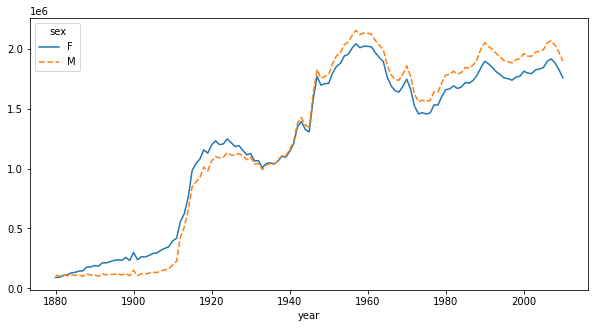

In [210]:
# Mostramos un diagrama de líneas para ver la evolución de nacimientos en el tiempo

plt.figure(figsize=(10, 5))
sns.lineplot(data=total_births)
plt.show()

In [211]:
# Calculamos el porcentaje de nacimientos que tuvieron ese nombre para niños y niñas

def add_prop(group):
  group['prop'] = group['births'] / group['births'].sum()
  return group

data = data.groupby(['year', 'sex']).apply(add_prop)
data

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1690779,Zymaire,M,5,2010,0.000003
1690780,Zyonne,M,5,2010,0.000003
1690781,Zyquarius,M,5,2010,0.000003
1690782,Zyran,M,5,2010,0.000003


In [212]:
# Comprobamos que la suma de los valores anteriores es 1 para todos los años y sexo

data.groupby(['year', 'sex'])['prop'].sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2008  M      1.0
2009  F      1.0
      M      1.0
2010  F      1.0
      M      1.0
Name: prop, Length: 262, dtype: float64

In [217]:
# Nos quedamos con los mil nombres más populares de niño y niña para cada año

def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

top1000 = data.groupby(['year', 'sex']).apply(get_top1000)
top1000.reset_index(inplace=True, drop=True)  # Eliminamos el índice del grupo, que no aporta nada
top1000

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


## Tendencia de los nombres

In [220]:
# Creamos una tabla resumen con el número de nacimientos para los nombres más populares en el top 1000 para cada año

total_births = top1000.pivot_table(values='births', index='year', columns='name', aggfunc=sum)
total_births

name,Aaden,Aaliyah,Aarav,Aaron,Aarush,Ab,Abagail,Abb,Abbey,Abbie,Abbigail,Abbott,Abby,Abdiel,Abdul,Abdullah,Abe,Abel,Abelardo,Abigail,Abigale,Abigayle,Abner,Abraham,Abram,Abril,Ace,Acie,Ada,Adah,Adalberto,Adaline,Adalyn,Adalynn,Adam,Adamaris,Adams,Adan,Adda,Addie,...,Zayden,Zayne,Zeb,Zebulon,Zechariah,Zed,Zeke,Zela,Zelda,Zelia,Zella,Zelma,Zelpha,Zena,Zenas,Zenia,Zennie,Zeno,Zenobia,Zeta,Zetta,Zettie,Zhane,Zigmund,Zillah,Zilpah,Zilpha,Zina,Zion,Zita,Zoa,Zoe,Zoey,Zoie,Zola,Zollie,Zona,Zora,Zula,Zuri
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1880,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,71.0,NaN,NaN,6.0,NaN,NaN,NaN,50.0,9.0,NaN,12.0,NaN,NaN,27.0,81.0,21.0,NaN,NaN,NaN,652.0,24.0,NaN,23.0,NaN,NaN,104.0,NaN,NaN,NaN,14.0,282.0,...,NaN,NaN,10.0,NaN,NaN,NaN,6.0,NaN,6.0,NaN,31.0,19.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,8.0,23.0,NaN,NaN,7.0,NaN,8.0,28.0,27.0,NaN
1881,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN,7.0,NaN,NaN,NaN,36.0,12.0,NaN,8.0,NaN,NaN,30.0,86.0,30.0,NaN,NaN,6.0,628.0,29.0,NaN,18.0,NaN,NaN,116.0,NaN,NaN,NaN,20.0,294.0,...,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,17.0,NaN,6.0,NaN,NaN,NaN,NaN,6.0,NaN,7.0,NaN,NaN,NaN,7.0,9.0,6.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,10.0,NaN,9.0,21.0,27.0,NaN
1882,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,11.0,NaN,NaN,NaN,50.0,10.0,NaN,14.0,NaN,NaN,32.0,91.0,25.0,NaN,8.0,NaN,689.0,27.0,NaN,16.0,NaN,NaN,114.0,NaN,NaN,NaN,17.0,347.0,...,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,50.0,21.0,NaN,6.0,NaN,NaN,NaN,NaN,7.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0,25.0,NaN,NaN,9.0,NaN,17.0,32.0,21.0,NaN
1883,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,12.0,NaN,11.0,NaN,NaN,27.0,52.0,20.0,NaN,6.0,NaN,778.0,41.0,NaN,11.0,NaN,NaN,107.0,NaN,NaN,NaN,24.0,369.0,...,NaN,NaN,13.0,NaN,NaN,NaN,6.0,NaN,NaN,5.0,55.0,16.0,NaN,13.0,NaN,NaN,NaN,6.0,5.0,NaN,15.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN,10.0,NaN,11.0,35.0,25.0,NaN
1884,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,98.0,NaN,NaN,6.0,NaN,NaN,NaN,45.0,14.0,NaN,13.0,NaN,NaN,33.0,67.0,29.0,NaN,NaN,NaN,854.0,33.0,NaN,20.0,NaN,NaN,83.0,NaN,NaN,NaN,18.0,364.0,...,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,63.0,29.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9.0,NaN,NaN,NaN,NaN,6.0,7.0,NaN,11.0,13.0,31.0,NaN,NaN,14.0,6.0,8.0,58.0,27.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,NaN,3737.0,NaN,8279.0,NaN,NaN,297.0,NaN,404.0,440.0,630.0,NaN,1682.0,NaN,NaN,219.0,NaN,922.0,NaN,15615.0,297.0,351.0,NaN,2200.0,414.0,316.0,240.0,NaN,397.0,NaN,NaN,NaN,NaN,NaN,6775.0,286.0,NaN,1098.0,NaN,NaN,...,224.0,196.0,NaN,NaN,336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1635.0,NaN,NaN,5145.0,2839.0,530.0,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,3941.0,NaN,8914.0,NaN,NaN,313.0,NaN,349.0,468.0,651.0,NaN,1573.0,NaN,NaN,224.0,NaN,939.0,NaN,15447.0,285.0,314.0,NaN,2139.0,463.0,736.0,279.0,NaN,460.0,NaN,NaN,NaN,316.0,NaN,6770.0,285.0,NaN,1080.0,NaN,NaN,...,429.0,201.0,NaN,NaN,362.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2069.0,NaN,NaN,4925.0,3028.0,526.0,NaN,NaN,NaN,NaN,NaN,NaN
2008,955.0,4028.0,219.0,8511.0,NaN,NaN,317.0,NaN,344.0,400.0,608.0,NaN,1328.0,199.0,NaN,210.0,NaN,863.0,NaN,15045.0,NaN,288.0,NaN,2143.0,477.0,585.0,322.0,NaN,520.0,NaN,NaN,NaN,576.0,328.0,6074.0,NaN,NaN,1110.0,NaN,NaN,...,563.0,267.0,NaN,NaN,365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2027.0,NaN,NaN,4764.0,3438.0,492.0,NaN,NaN,NaN,NaN,NaN,NaN


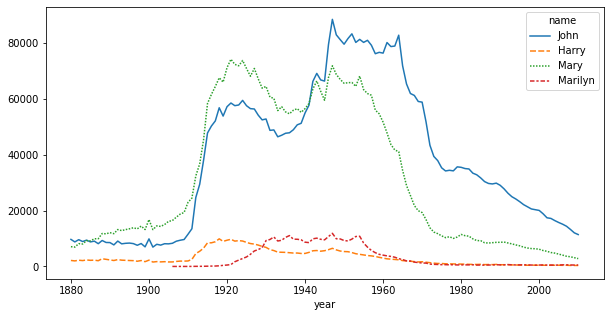

In [221]:
# Mostramos un diagrama de líneas con la evolución de cuatro de los nombres

plt.figure(figsize=(10, 5))
sns.lineplot(data=total_births[['John', 'Harry', 'Mary', 'Marilyn']])
plt.show()

## Midiendo la diversidad de nombres

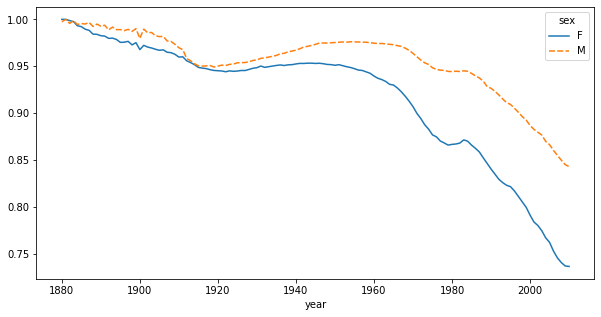

In [222]:
# Calculamos el porcentaje de nombres que supone sobre el total los 1000 primeros
# Esto muestra la diversidad de nombres que han ido apareciendo

table = top1000.pivot_table(values='prop', index='year', columns='sex', aggfunc=sum)

plt.figure(figsize=(10, 5))
sns.lineplot(data=table)
plt.show()

In [223]:
# Nombres de niños en el año 2010

boys = top1000[top1000['sex'] == 'M']  # Nos quedamos con los nombres de niños
df = boys[boys['year'] == 2010]
df

,name,sex,births,year,prop
260877,Jacob,M,21875,2010,0.011523
260878,Ethan,M,17866,2010,0.009411
260879,Michael,M,17133,2010,0.009025
260880,Jayden,M,17030,2010,0.008971
260881,William,M,16870,2010,0.008887
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


In [224]:
# Calculamos cuántos nombres acumulan el 50% de los nacimientos

prop_cumsum = df.sort_values(by='prop', ascending=False)['prop'].cumsum()
prop_cumsum.values.searchsorted(0.5) + 1  # Busca en qué posición de la lista caería el valor 0.5

117

In [225]:
# Repetimos el cálculo anterior pero para el año 1900

df = boys[boys['year'] == 1900]
prop_cumsum = df.sort_values(by='prop', ascending=False)['prop'].cumsum()
prop_cumsum.values.searchsorted(0.5) + 1

25

In [226]:
top1000.groupby(['year', 'sex']).sum()

births      prop
year sex                   
1880 F      90993  1.000000
     M     110203  0.997375
1881 F      91955  1.000000
     M     100748  1.000000
1882 F     107711  0.998702
...           ...       ...
2008 M    1727470  0.850003
2009 F    1347502  0.737290
     M    1667993  0.845256
2010 F    1296004  0.736780
     M    1600633  0.843156

[262 rows x 2 columns]

In [228]:
# Hacemos el cálculo (cuántos nombres permiten acumular el 50% de los nacimientos)
# Se hace para todos los años y tanto para niños como para niñas

def get_quantile_count(group):
  group = group.sort_values(by='prop', ascending=False)
  return group['prop'].cumsum().values.searchsorted(0.5) + 1

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')
diversity

sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16
...,...,...
2006,209,99
2007,223,103
2008,234,109


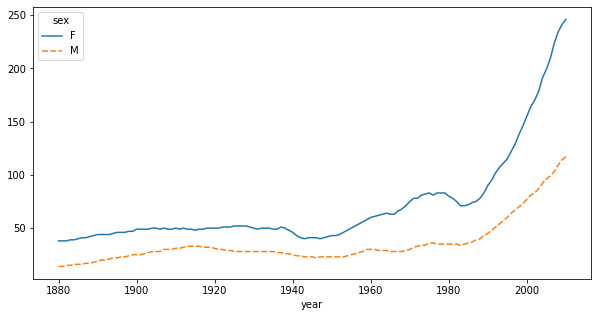

In [230]:
# Mostramos la gráfica con cuántos nombres acumulan el 50% de nacimientos

plt.figure(figsize=(10, 5))
sns.lineplot(data=diversity)
plt.show()

## La revolución de la última letra

In [232]:
# Creamos una tabla que resume, por sexo y años, el número de niños y niñas cuyo nombre acaba en cada letra

get_last_letter = lambda x: x[-1]
last_letters = data['name'].map(get_last_letter)  # Sacamos la última letra de cada palabra
table = data.pivot_table(values='births', index=last_letters, columns=['sex', 'year'], aggfunc=sum)
table

sex         F                    ...         M                    
year     1880     1881     1882  ...      2008      2009      2010
name                             ...                              
a     31446.0  31581.0  36536.0  ...   32901.0   31430.0   28438.0
b         NaN      NaN      NaN  ...   39945.0   38862.0   38859.0
c         NaN      NaN      5.0  ...   25318.0   24048.0   23125.0
d       609.0    607.0    734.0  ...   47910.0   46172.0   44398.0
e     33378.0  34080.0  40399.0  ...  140966.0  135496.0  129012.0
f         NaN      NaN      NaN  ...    2195.0    2212.0    2255.0
g         7.0      5.0     12.0  ...    2059.0    2396.0    2666.0
h      4863.0   4784.0   5567.0  ...  100250.0   99979.0   98090.0
i        61.0     78.0     81.0  ...   38151.0   40912.0   42956.0
j         NaN      NaN      NaN  ...    1381.0    1416.0    1459.0
k        13.0     15.0     11.0  ...   39563.0   37507.0   35198.0
l      2541.0   2911.0   3527.0  ...  150791.0  143751.0  133583.0
m        58.0     57.0     81.0  ...   44316.0   46278.0   46808.0
n      3008.0   2959.0   3576.0  ...  733869.0  715388.0  688677.0
o        30.0     49.0     35.0  ...   91485.0   86423.0   81025.0
p         NaN      NaN      NaN  ...    2637.0    2595.0    2409.0
q         NaN      NaN      NaN  ...     339.0     377.0     342.0
r       481.0    417.0    590.0  ...  174632.0  173200.0  166064.0
s      1391.0   1316.0   1637.0  ...  137056.0  129861.0  123670.0
t      2152.0   2165.0   2399.0  ...   43846.0   43674.0   43398.0
u       380.0    427.0    410.0  ...    2405.0    2417.0    2318.0
v         NaN      NaN      NaN  ...    2418.0    2589.0    2723.0
w         NaN      5.0      NaN  ...   36937.0   33181.0   30656.0
x         NaN      NaN      NaN  ...   14834.0   16640.0   16352.0
y     10469.0  10404.0  12145.0  ...  122633.0  112922.0  110425.0
z       106.0     95.0    106.0  ...    3473.0    3633.0    3476.0

[26 rows x 262 columns]

In [233]:
# Nos quedamos con un subconjunto de tres años

subtable = table.reindex(columns=[1910, 1960, 2010], level='year')
subtable

sex          F                            M                    
year      1910      1960      2010     1910      1960      2010
name                                                           
a     108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b          NaN     694.0     450.0    411.0    3912.0   38859.0
c          5.0      49.0     946.0    482.0   15476.0   23125.0
d       6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e     133569.0  435013.0  313833.0  28655.0  178823.0  129012.0
f          NaN      20.0      97.0    152.0    9224.0    2255.0
g         57.0     318.0     657.0    437.0   20235.0    2666.0
h      20427.0   73247.0  133424.0   8848.0   80841.0   98090.0
i        605.0   80812.0   55820.0    164.0    1286.0   42956.0
j          NaN       NaN     159.0      NaN       NaN    1459.0
k         48.0     315.0     626.0   7104.0  105315.0   35198.0
l      17121.0   68482.0   46360.0  12626.0  223716.0  133583.0
m        476.0   17417.0    4552.0  11272.0   72139.0   46808.0
n      31412.0  264258.0  246631.0  27851.0  325266.0  688677.0
o        658.0    4932.0    2187.0   3314.0   27358.0   81025.0
p          7.0      47.0      35.0    616.0   12102.0    2409.0
q          NaN       NaN      53.0      NaN       NaN     342.0
r       5308.0   13677.0   31707.0  12522.0   66183.0  166064.0
s      15477.0   25810.0   23451.0  25404.0  219080.0  123670.0
t      10877.0   30738.0   13773.0  14153.0  140015.0   43398.0
u        271.0    1161.0     734.0     24.0     122.0    2318.0
v          NaN     122.0     205.0     22.0      78.0    2723.0
w          8.0      63.0    2080.0   1229.0   16444.0   30656.0
x          6.0      74.0    1279.0    770.0    3947.0   16352.0
y      43991.0  308504.0  205501.0  15021.0  343318.0  110425.0
z        967.0    1333.0    1238.0     33.0     392.0    3476.0

In [234]:
# Sustituimos el número de ocurrencias de cada letra por su probabilidad de ocurrencia 

letter_prop = subtable / subtable.sum()
letter_prop

sex          F                             M                    
year      1910      1960      2010      1910      1960      2010
name                                                            
a     0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b          NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c     0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d     0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e     0.336941  0.215133  0.178415  0.147556  0.083853  0.067959
f          NaN  0.000010  0.000055  0.000783  0.004325  0.001188
g     0.000144  0.000157  0.000374  0.002250  0.009488  0.001404
h     0.051529  0.036224  0.075852  0.045562  0.037907  0.051670
i     0.001526  0.039965  0.031734  0.000844  0.000603  0.022628
j          NaN       NaN  0.000090       NaN       NaN  0.000769
k     0.000121  0.000156  0.000356  0.036581  0.049384  0.018541
l     0.043189  0.033867  0.026356  0.065016  0.104904  0.070367
m     0.001201  0.008613  0.002588  0.058044  0.033827  0.024657
n     0.079240  0.130687  0.140210  0.143415  0.152522  0.362771
o     0.001660  0.002439  0.001243  0.017065  0.012829  0.042681
p     0.000018  0.000023  0.000020  0.003172  0.005675  0.001269
q          NaN       NaN  0.000030       NaN       NaN  0.000180
r     0.013390  0.006764  0.018025  0.064481  0.031034  0.087477
s     0.039042  0.012764  0.013332  0.130815  0.102730  0.065145
t     0.027438  0.015201  0.007830  0.072879  0.065655  0.022861
u     0.000684  0.000574  0.000417  0.000124  0.000057  0.001221
v          NaN  0.000060  0.000117  0.000113  0.000037  0.001434
w     0.000020  0.000031  0.001182  0.006329  0.007711  0.016148
x     0.000015  0.000037  0.000727  0.003965  0.001851  0.008614
y     0.110972  0.152569  0.116828  0.077349  0.160987  0.058168
z     0.002439  0.000659  0.000704  0.000170  0.000184  0.001831

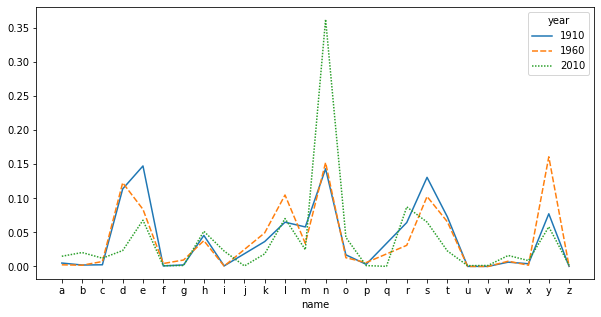

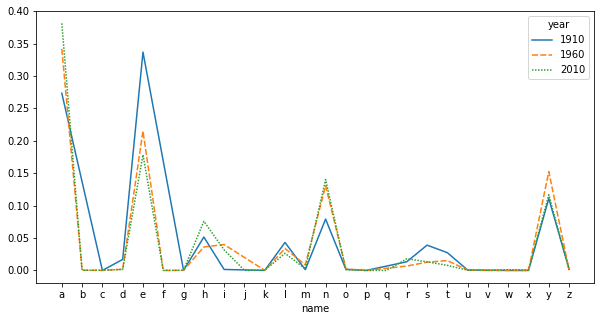

In [235]:
# Cómo han evolucionado los nombres terminados en cada letra para cada uno de los años

plt.figure(figsize=(10, 5))
sns.lineplot(data=letter_prop['M'])  # Nombres de niños
plt.show()
plt.figure(figsize=(10, 5))
sns.lineplot(data=letter_prop['F'])  # Nombres de niñas
plt.show()

In [237]:
# Vemos como evolucionan tres de las letras para los niños

letter_prop = table / table.sum()  # Calculamos el porcentaje que representa cada letra en cada año
dny_ts = letter_prop.loc[['d', 'n', 'y'], 'M'].T
dny_ts

name,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405
...,...,...,...
2006,0.025075,0.351666,0.060338
2007,0.024451,0.358274,0.059634
2008,0.023574,0.361101,0.060342


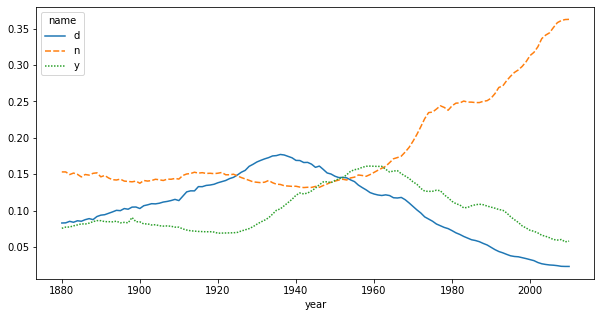

In [238]:
# La gráfica muestra cómo evolucionan las terminaciones 'd', 'n' e 'y' a lo largo de los años

plt.figure(figsize=(10, 5))
sns.lineplot(data=dny_ts)
plt.show()

## Nombres que cambiaron de sexo

In [239]:
# Obtenemos todos los nombres que contienen 'lesl'

all_names = pd.Series(top1000['name'].unique())  # Lista con todos los nombres en el top 1000
lesley_like = all_names[all_names.str.lower().str.contains('lesl')]  # Nombres que contienen 'lesl'
lesley_like

632     Leslie
2294    Lesley
4262    Leslee
4728     Lesli
6103     Lesly
dtype: object

In [240]:
# Contamos el número de nacimientos cuyo nombre empieza por 'lesl'

filtered = top1000[top1000['name'].isin(lesley_like)]
filtered.groupby('name')['births'].sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

In [242]:
# Calculamos, para los nombres que empiezan por 'lesl', qué porcentaje son niños y cuál niñas para cada año

table = filtered.pivot_table(values='births', index='year', columns='sex', aggfunc='sum')
table = table.div(table.sum(1), axis=0)  # Obtiene el porcentaje de ocurrencias entre niños y niñas
table

sex,F,M
year,,
1880,0.091954,0.908046
1881,0.106796,0.893204
1882,0.065693,0.934307
1883,0.053030,0.946970
1884,0.107143,0.892857
...,...,...
2006,1.000000,NaN
2007,1.000000,NaN
2008,1.000000,NaN


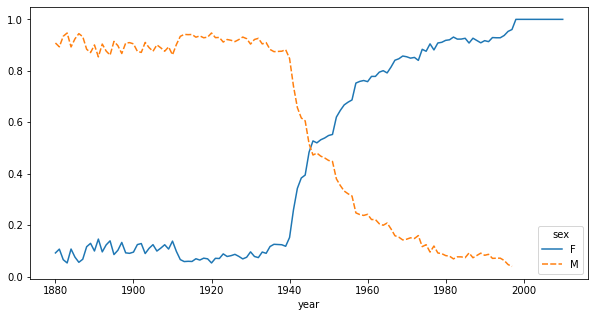

In [243]:
# Mostramos cómo han evolucionado los nombres 'lesl' para niños y niñas con los años

plt.figure(figsize=(10, 5))
sns.lineplot(data=table)
plt.show()

## Referencias

* [Python for Data Analysis](https://github.com/wesm/pydata-book/blob/2nd-edition/ch14.ipynb)